# Portfolio 1 - Analysis of Cycling Data

In [1]:
import sys
sys.path.append("../used_functions")
import custom_functions as custfun
import importlib
importlib.reload(custfun)
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from datetime import timedelta
import re
import warnings
%matplotlib inline
plt.style.use("ggplot")

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [2]:
# Loading strava_exoport.csv
strava = pd.read_csv('data/strava_export.csv', index_col = 'date', parse_dates = True)

# Converting the timezone to Aus/Syd
strava.index = strava.index.tz_localize('Australia/Sydney')                                 

print("Shape of the dataframe(row, column) : ", strava.shape)
strava.head()

Shape of the dataframe(row, column) :  (268, 10)


,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-02 20:47:51+11:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 01:36:53+11:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 02:56:00+11:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 05:37:04+11:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-05 19:22:46+11:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride


The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [3]:
# Loading the data from cheetah.csv
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace = True)                

# Setting combination of time and date as index
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])         

# Converting the timezone to Aus/Syd
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')                   

print("Shape of the dataframe(row, column) : ", cheetah.shape)
cheetah.head()

Shape of the dataframe(row, column) :  (251, 362)


,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.75452,16.6520,1.31920,1.67755,223.621,0.83441,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.84343,80.2669,1.21137,1.54250,246.185,0.91860,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,02/01/18,08:13:34,2018_02_01_08_13_34.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.82714,78.8866,1.35775,1.86002,254.409,0.94929,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.81422,159.4590,1.47188,1.74658,233.780,0.87231,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in their documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).  

## Your Tasks

Your first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [4]:
# Carrying out inner join on both dataframe
## strava_plus_cheetah = strava.join(cheetah, how = "inner")                        

## Join is not working due to some problems so reading csv file
strava_plus_cheetah = pd.read_csv("data/strava_plus_cheetah.csv", parse_dates = True)

# Setting an index
strava_plus_cheetah.index = strava_plus_cheetah["index"]

# Deleting index column and name of index of df
del strava_plus_cheetah["index"]
del strava_plus_cheetah.index.name

print("Shape of the dataframe(row, column) :", strava_plus_cheetah.shape)
strava_plus_cheetah.head()

Shape of the dataframe(row, column) : (243, 372)


,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,109.8,19.0,143.0,False,26.3,649,612.00 m,6,113,Ride,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


## Required Analysis


### 1. Remove rides with no measured power (where device_watts is False) - these are commutes or MTB rides

In [5]:
# Creating a boolean flag based on condition devise_watts is false
flag = strava_plus_cheetah["device_watts"] != False                                   
                                                                                      
# Filtering data based on boolean flag
strava_plus_cheetah = strava_plus_cheetah[flag]                                       

print("Shape of the dataframe(row, column) :", strava_plus_cheetah.shape)

## strava_plus_cheetah = strava_plus_cheetah.drop((strava_plus_cheetah[not flag]).index)# Another way to achieve above task 

Shape of the dataframe(row, column) : (209, 372)


### 2. Look at the distributions of some key variables: time, distance, average speed, average power, TSS. Are they normally distributed? Skewed? 

### 2.0 Setting matplotlib parameters

In [6]:
mpl.rcParams['axes.titlesize'] = 22                                                 # -Change title size of a plot
mpl.rcParams['axes.labelsize'] = 16                                                 # -Change label size(x and y) of a plot
mpl.rcParams['xtick.labelsize'] = 15                                                # -Change xticks size of a plot
mpl.rcParams['ytick.labelsize'] = 15                                                # -Change yticks size of a plot

### 2.1 moving_time

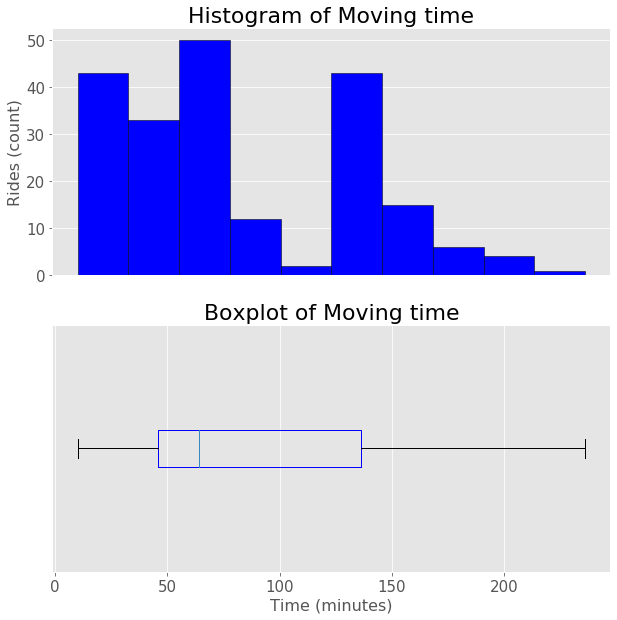

In [7]:
# For more detials about this function check used_function/custom_functions.py
custfun.create_histogram_plus_boxplot(strava_plus_cheetah["moving_time"], "Moving time", "blue", 
                                      "Rides (count)", "Time (minutes)", (10, 10))

### Graph Explanation
#### moving_time : Time spent moving on a bike(in Minutes)
By looking at the histogram and boxplot, One can say that the distribution is not normal. In fact it is **right skewed**(Right box is longer than left box in boxplot). Generally such type of distribution is called **bimodal**(<a href = "#B.-Density-plots">check density plot below</a>) as you can see two peaks in histogram(one at median value approx, 65 minutes and another peak at approx. 135 minutes). We can also figure out following from the boxplot. **Boxplots are also called 5 number summary.**
*  Median(Q2) ~= 65 mintues (50% of the rides have moving time less than 65 minutes **OR** 50% of the rides have moving time greater than 65 minutes)
*  1st Quartile(Q1) ~= 45 minutes (25% of the rides have moving time below 45 minutes)
*  3rd Quartile(Q3) ~= 135 minutes (75% of the rides have moving time below 135 minutes **OR** 25% of the rides have moving time above 135 minutes)
*  Minimun ~= 10 minutes (Minimun moving time amongst all the rides - left end of the whisker)
*  Maximum ~= 240 minutes (Maximum moving time amongst all the rides - right end of the whisker)

*No outliers are detected*

### 2.2 elapsed_time

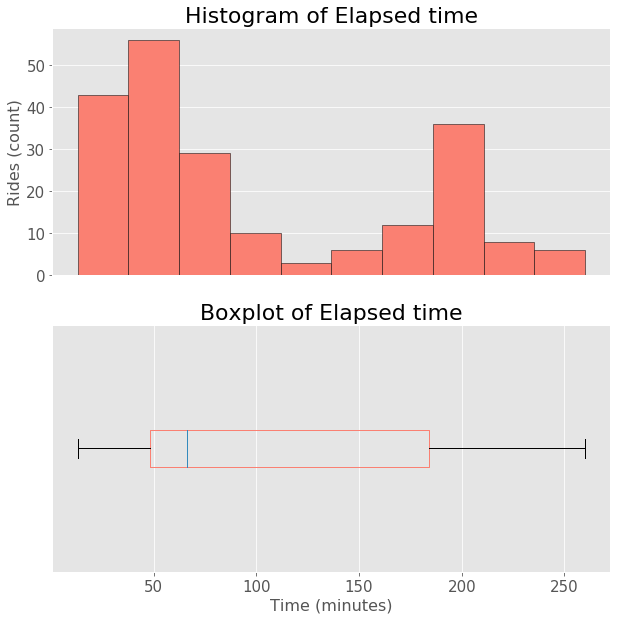

In [8]:
# For more detials about this function check used_function/custom_functions.py
custfun.create_histogram_plus_boxplot(strava_plus_cheetah["elapsed_time"], "Elapsed time", "salmon",
                                      "Rides (count)", "Time (minutes)", (10, 10))

### Graph Explanation
#### elapsed_time : Total time spent on a bike including standing at traffic lights and resting (in Minutes)
Distribution is not normal. In fact it is **right skewed**(Right box is longer than left box in boxplot). Generally such type of distribution is called **bimodal**(<a href = "#B.-Density-plots">check density plot below</a>) as you can see two peaks in histogram(one at median value approx, 70 minutes and another peak at approx. 200 minutes). We can also figure out following from the boxplot. **Boxplots are also called 5 number summary.**
*  Median(Q2) ~= 70 mintues (50% of the rides have elapsed time below 70 minutes)
*  1st Quartile(Q1) ~= 50 minutes (25% of the rides have elapsed time below 50 minutes)
*  3rd Quartile(Q3) ~= 180 minutes (75% of the rides have elapsed time below 180 minutes **OR** 25% of the rides have moving time above 180 minutes)
*  Minimun ~= 13 minutes (Minimun elapsed time amongst all the rides - left end of the whisker)
*  Maximum ~= 265 minutes (Maximum elapsed time amongst all the rides - right end of the whisker)

*No outliers are detected*

### 2.3 distance

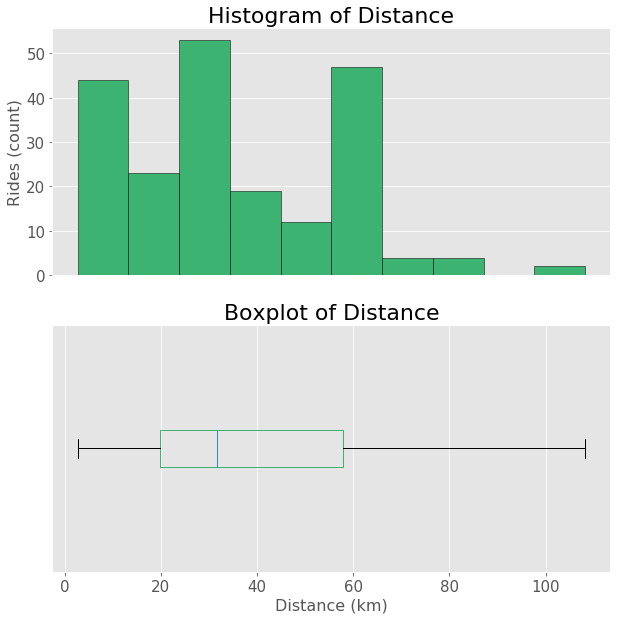

In [9]:
# Removing the rows where distance = 0 km
strava_plus_cheetah = strava_plus_cheetah[strava_plus_cheetah["distance"] != 0]  

# For more detials about this function check used_function/custom_functions.py
custfun.create_histogram_plus_boxplot(strava_plus_cheetah["distance"], "Distance", "mediumseagreen", 
                                      "Rides (count)", "Distance (km)", (10, 10))

### Graph Explanation
#### Distance : Total Distance travelled on a bike (in KM)

Distribution is **right skewed**(Right box is longer than left box in boxplot). Generally such type of distribution is called **bimodal**(<a href = "#B.-Density-plots">check density plot below</a>) as you can see two peaks in histogram(one at median value approx, 30 km and another peak at approx. 60 km). We can also figure out following from the boxplot. **Boxplots are also called 5 number summary.**
*  Median(Q2) ~= 30 km (50% of the rides have travelled distance below 30 km)
*  1st Quartile(Q1) ~= 20 km (25% of the rides have travelled distance below 20 km)
*  3rd Quartile(Q3) ~= 58 km (75% of the rides have travelled distance below 58 km **OR** 25% of the rides have travelled distance above 58 km)
*  Minimun ~= 3 km (Minimun distance travelled amongst all the rides - left end of the whisker)
*  Maximum ~= 110 km (Maximum distance travelled amongst all the rides - right end of the whisker)

*No outliers are detected*

### 2.4 average speed

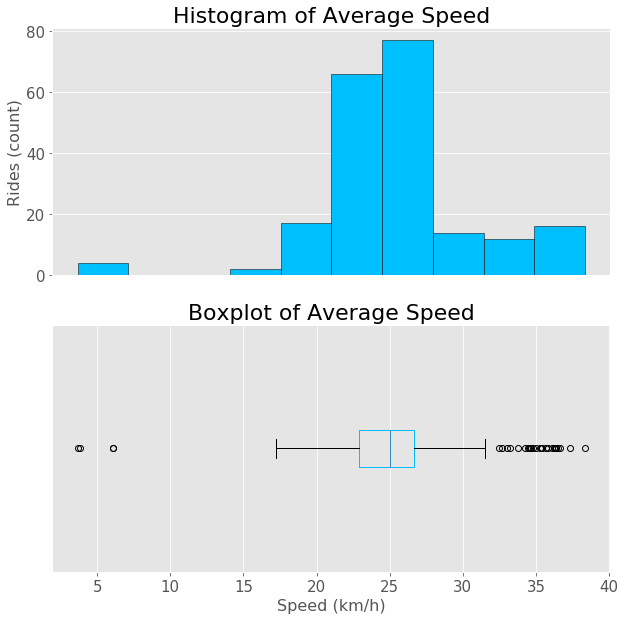

In [10]:
# For more detials about this function check used_function/custom_functions.py
custfun.create_histogram_plus_boxplot(strava_plus_cheetah["Average Speed"], "Average Speed", "deepskyblue",
                                      "Rides (count)", "Speed (km/h)", (10, 10))

### Graph Explanation
#### Average Speed : Average Speed of a bike (in km/h)

Distribution is **nearly normal**(Right box has almost equal length as left box in boxplot)(<a href = "#B.-Density-plots">check density plot below</a>). We can also figure out following from the boxplot. **Boxplots are also called 5 number summary.**
*  Median(Q2) ~= 25 km/h (50% of the rides have speed below 25 km/h)
*  1st Quartile(Q1) ~= 23 km/h (25% of the rides have speed below 23 km/h)
*  3rd Quartile(Q3) ~= 26 km/h (75% of the rides have speed below 26 km/h **OR** 25% of the rides have speed above 26 km/h)
*  Minimun ~= 18 km/h (Minimun average speed amongst all the rides - left end of the whisker)
*  Maximum ~= 32 km/h (Maximum average speed amongst all the rides - right end of the whisker)

**Outliers detected**
*  Outliers less than 7 km/h and and more than 32 km/h 

### 2.5 average power

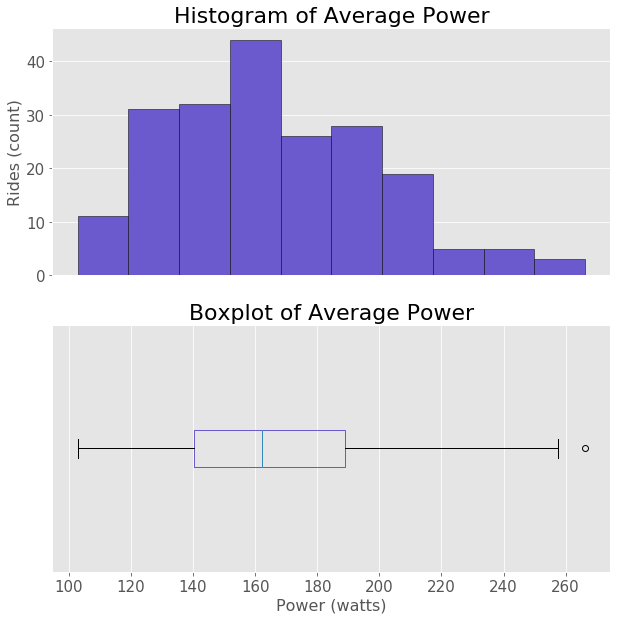

In [11]:
# Removing rows where Average power = 0
strava_plus_cheetah = strava_plus_cheetah[strava_plus_cheetah["Average Power"] != 0] 

# For more detials about this function check used_function/custom_functions.py
custfun.create_histogram_plus_boxplot(strava_plus_cheetah["Average Power"], "Average Power", "slateblue",
                                      "Rides (count)", "Power (watts)", (10, 10))

### Graph Explanation
#### Average Power : Average Power of a bike (in watts)

Distribution is **normal**(<a href = "#B.-Density-plots">check density plot below</a>). We can also figure out following from the boxplot. **Boxplots are also called 5 number summary.**
*  Median(Q2) ~= 155 watts (50% of the rides generated power below 155 watts)
*  1st Quartile(Q1) ~= 125 watts (25% of the rides generated power below 125 watts)
*  3rd Quartile(Q3) ~= 180 watts (75% of the rides generated power below 180 watts **OR** 25% of the rides have speed above 180 watts)
*  Minimun ~= 100 watts (Minimun average power amongst all the rides - left end of the whisker)
*  Maximum ~= 260 watts (Maximum average power amongst all the rides - right end of the whisker)

**Outliers detected**
*  Outliers having average power more than 260 watts 

### 2.6 TSS

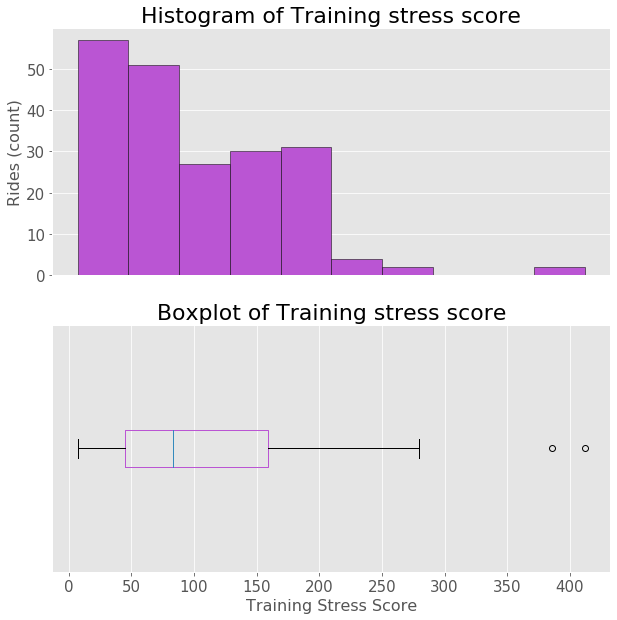

In [12]:
# For more detials about this function check used_function/custom_functions.py
custfun.create_histogram_plus_boxplot(strava_plus_cheetah["TSS"], "Training stress score", "mediumorchid",
                                      "Rides (count)", "Training Stress Score", (10, 10))

### Graph Explanation
#### Training Stress Score

Distribution is **Right skewed**(Right box has more length than left box in boxplot)(<a href = "#B.-Density-plots">check density plot below</a>). We can also figure out following from the boxplot. **Boxplots are also called 5 number summary.**
*  Median(Q2) ~= 80 (50% of the rides have TSS below 80)
*  1st Quartile(Q1) ~= 30 (25% of the rides have TSS below 30)
*  3rd Quartile(Q3) ~= 150 (75% of the rides have TSS below 150 **OR** 25% of the rides have TSS above 150)
*  Minimun ~= 0 (Minimun TSS amongst all the rides - left end of the whisker)
*  Maximum ~= 280 (Maximum TSS amongst all the rides - right end of the whisker)

**Outliers detected**
*  Outliers detected around 400 TSS. 

### Other ways to plot the graphs(Rather than plotting all of them individually you can use below code)
Plotting them together helps us to compare the characterstics of variables with other variables

#### A. Histograms

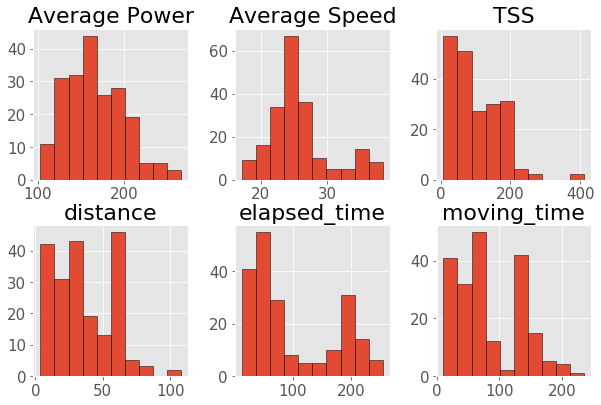

In [13]:
## Histograms

# Selecting requied columns
new_dataframe = strava_plus_cheetah[["distance", "moving_time", "elapsed_time" ,  "Average Speed", 
                                         "Average Power", "TSS"]]                           

# Plotting a histogram
new_dataframe.hist(figsize = (10, 10), edgecolor = "black", layout = (3, 3))                 
plt.show()

## We are only interesed in distributions of the variables that's why labels and units are not displayed on the x-axis.

#### B. Density plots

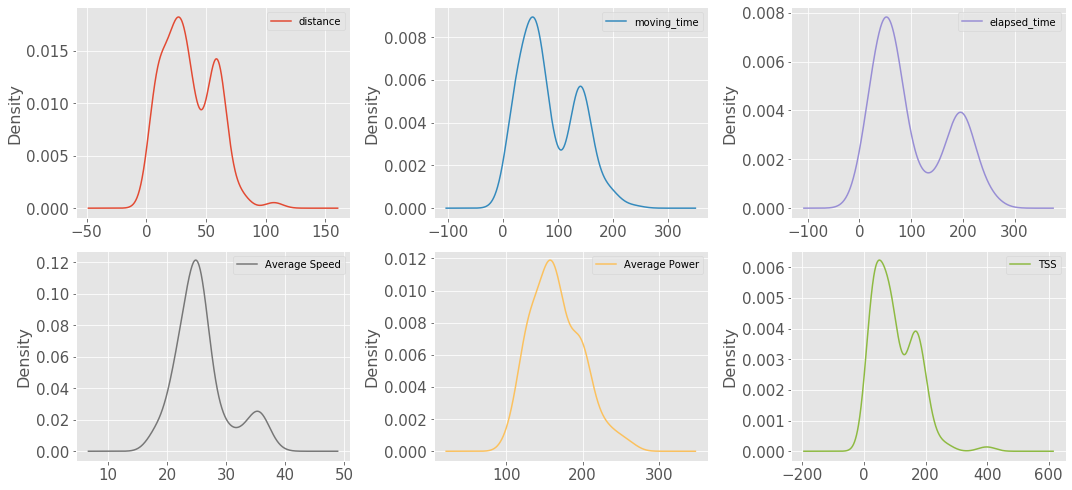

In [14]:
## Density plot shows density curves. It can be useful to easily identify the distribution of the variables.

# Plotting density curves
new_dataframe.plot(kind='density', subplots = True, layout = (3, 3), 
                   figsize = (15, 10), sharex = False, sharey = False)    

# Spaces between subplots
plt.tight_layout()                                                       

plt.show()

## We are only interesed in distributions of the variables that's why labels and units are not displayed on the x-axis.

#### C. Boxplots

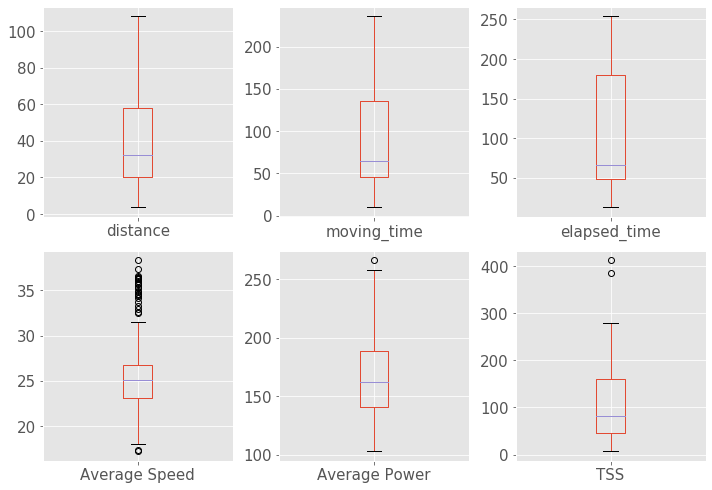

In [15]:
## Boxplots are also useful to identify how much variation a variable has. 

# Plotting the boxplots
new_dataframe.plot(kind='box', subplots = True, layout = (3, 3), 
                   figsize = (10,10), sharex = False, sharey = False)      

# Spaces between subplots
plt.tight_layout()                                                       

plt.show()

## We are only interesed in variation of the variables that's why labels and units are not displayed on the y-axis.

### 3. Explore the relationships between the following variables. Are any of them corrolated with each other (do they vary together in a predictable way)? Can you explain any relationships you observe?
*  Distance
*  Moving Time
*  Average Speed
*  Heart Rate
*  Power (watts)
*  Normalised power (NP)
*  Training Stress Score
*  Elevation Gain

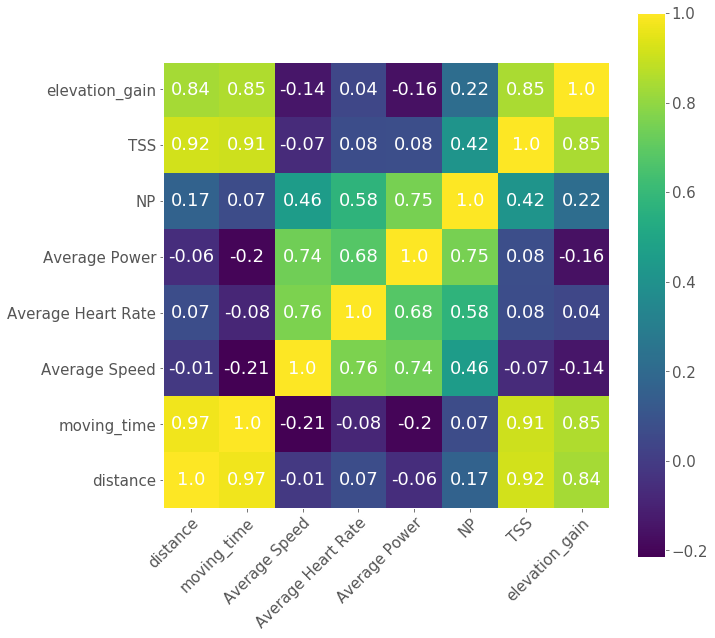

In [16]:
# Ignoring the simple warning for this cell
warnings.simplefilter(action = 'ignore')                                    

# Removing rows where Avg heart rate = 0
strava_plus_cheetah = strava_plus_cheetah[strava_plus_cheetah["Average Heart Rate"] != 0.0]   

# Getting required variables
variables_in_que3 = strava_plus_cheetah[["distance", "moving_time", "Average Speed", "Average Heart Rate", 
                                         "Average Power","NP", "TSS", "elevation_gain"]]

# Cleaning elevation_gain
# For more detials about this function check used_function/custom_functions.py
variables_in_que3["elevation_gain"] = custfun.clean_elevation_gain(variables_in_que3["elevation_gain"]) 

# Creating correlation matrix
# For more detials about this function check used_function/custom_functions.py
custfun.crete_correlogram(df = variables_in_que3, size = (10, 10), xlab_rotation = 45)

### Correlogram
*  Correlogram - Shows correlation between multiple numerical variables.
*  Correlation is a measure that determines the strength of linear relation between two numerical variables.
*  The value for correlation ranges between -1 and 1.
*  0 correlation means variables are independent of each other.
*  The closer the value of correlation between variables to -1 and 1 the stronger the relationship between them.
*  Negative correlation between x and y means if the value of x increases the value of y decreases and vice versa.
*  Positive correlation between x and y means if the value of x increases the value of y increases and vice versa.


#### Graph Explanation


*  Distance is strongly related to moving time(obvious), TSS and elevation gain(0.97, 0.92, 0.84). With the increase/decrease in Distance there will be strong increase/decrease in all three variables. And also it is weakly related to all other variables. We can also see that Distance is negatively weakly correlated with Average Speed. That makes sense as distance increases the speed will be sligly descreased. That also explains -0.06 correlation with average power(speed decreases, power generated by bike decreases).
*  High correlation of distance with Elevation gain means the rider rides his/her bike where there are more hills**(This suggests that Australia has more <a href = "https://english.stackexchange.com/questions/469106/what-do-you-call-a-road-that-goes-up-and-down">Undulate</a> roads)**. And due to hills rider's body is going to get under more stress due to riding up the hills(suggests more TSS).
*  Moving time is also highly correlated with TSS and elevation gain(0.91, 0.85). More moving time -> more distance -> more stress on body(due to travelling long distances in hill areas).
*  Average Speed is highly correlated with Average Power and NP(0.76, 0.74) for obvious reasons, moderately correlated Average Heart Rate(0.46). More speed -> more heart rate -> more power generated by bike. Average speed is weakly negatively correlated with moving time. It is obvious that if speed is increased rider needs less time to cover the distance.
*  NP is just smoothened power so it is believable that it is strongly correlated(0.75) with Average Power. And it will aslo be highly correlated with variables which were highly correlated with Average Power(**confounding**).
*  High correlation between elevation gain and moving time can be explained as more the ascent height, less the speed and more moving time.



### Other ways to observe any relation between variable 

#### 1. Scatterplot matrix

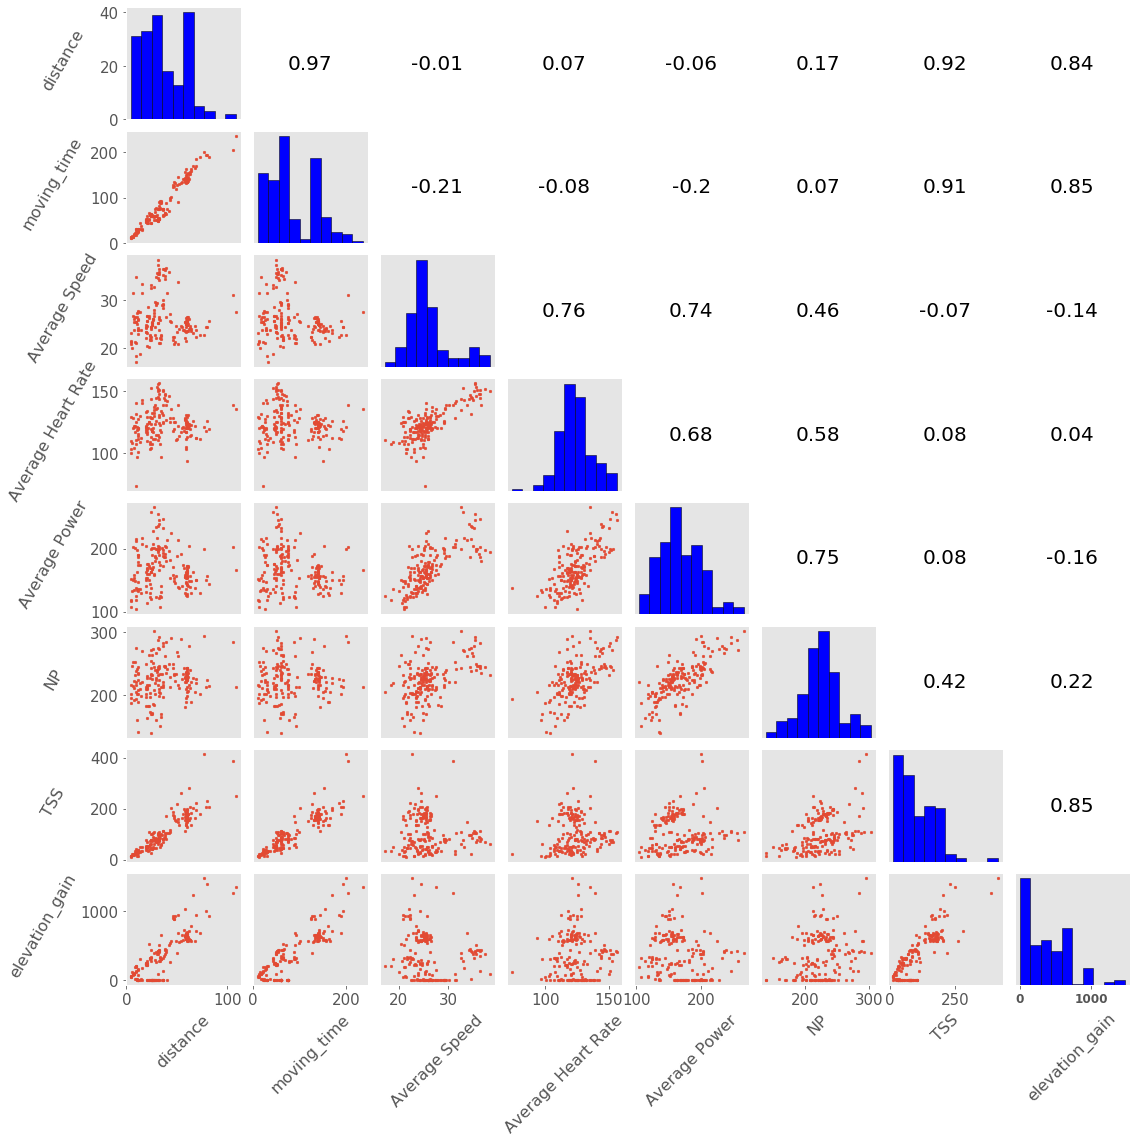

In [17]:
# For more detials about this function check used_function/custom_functions.py
custfun.create_scatter_matrix(variables_in_que3, xlab_rotation = 45, ylab_rotation = 60, 
                              xticklab_fontsize = 12, yticklab_fontsize = 12)

### Graph Explanation
*  You can see how two variables are varying(increasing/decreasing) together by looking at their scatter plot. Let's take an example of **distance** and **moving time**. By looking at the *first row second column* we can see that for high value of distance moving time is also high. The points are not scattered vertically much - this suggests that they are highly correlated. *You can observe other graphs just like that. The diagonal represents the histogram of respective variable*

### 4. We want to explore the differences between the three categories: Race, Workout and Ride.

#### 0. Some operations on dataframe before plotting the graphs

In [18]:
# Selecting important variables
important_dataframe = strava_plus_cheetah[["distance", "moving_time", "elapsed_time",
                                           "elevation_gain", "Gradient", "Average Speed", "Average Power","Average Heart Rate", 
                                           "Average Cadence", "Calories (HR)", "TSS", "kudos", "workout_type"]]
                                            
# Removing rows where heart rate is 0
important_dataframe = important_dataframe[important_dataframe["Average Heart Rate"] != 0] 

# Cleaning elevation_gain
# For more detials about this function check used_function/custom_functions.py
important_dataframe["elevation_gain"] = custfun.clean_elevation_gain(important_dataframe["elevation_gain"]) # -See documentation above



def process_workout_type():
    """
    Function that will create new list based on workout_type.
    New list will be containing integers 1, 2 and 3.
    where,
    1 : Ride
    2 : Workout
    3 : Race
    This is done to help plot graphs based on category.
    """
    temp_list = []
    for i in important_dataframe["workout_type"]:
        if i == "Ride":
            temp_list.append(1)
        elif i == "Workout":
            temp_list.append(2)
        else:
            temp_list.append(3)
    
    return temp_list

important_dataframe["workout_type_int"] = process_workout_type()

#### A. Use scatter plots with different colours for each category to explore how these categories differ.

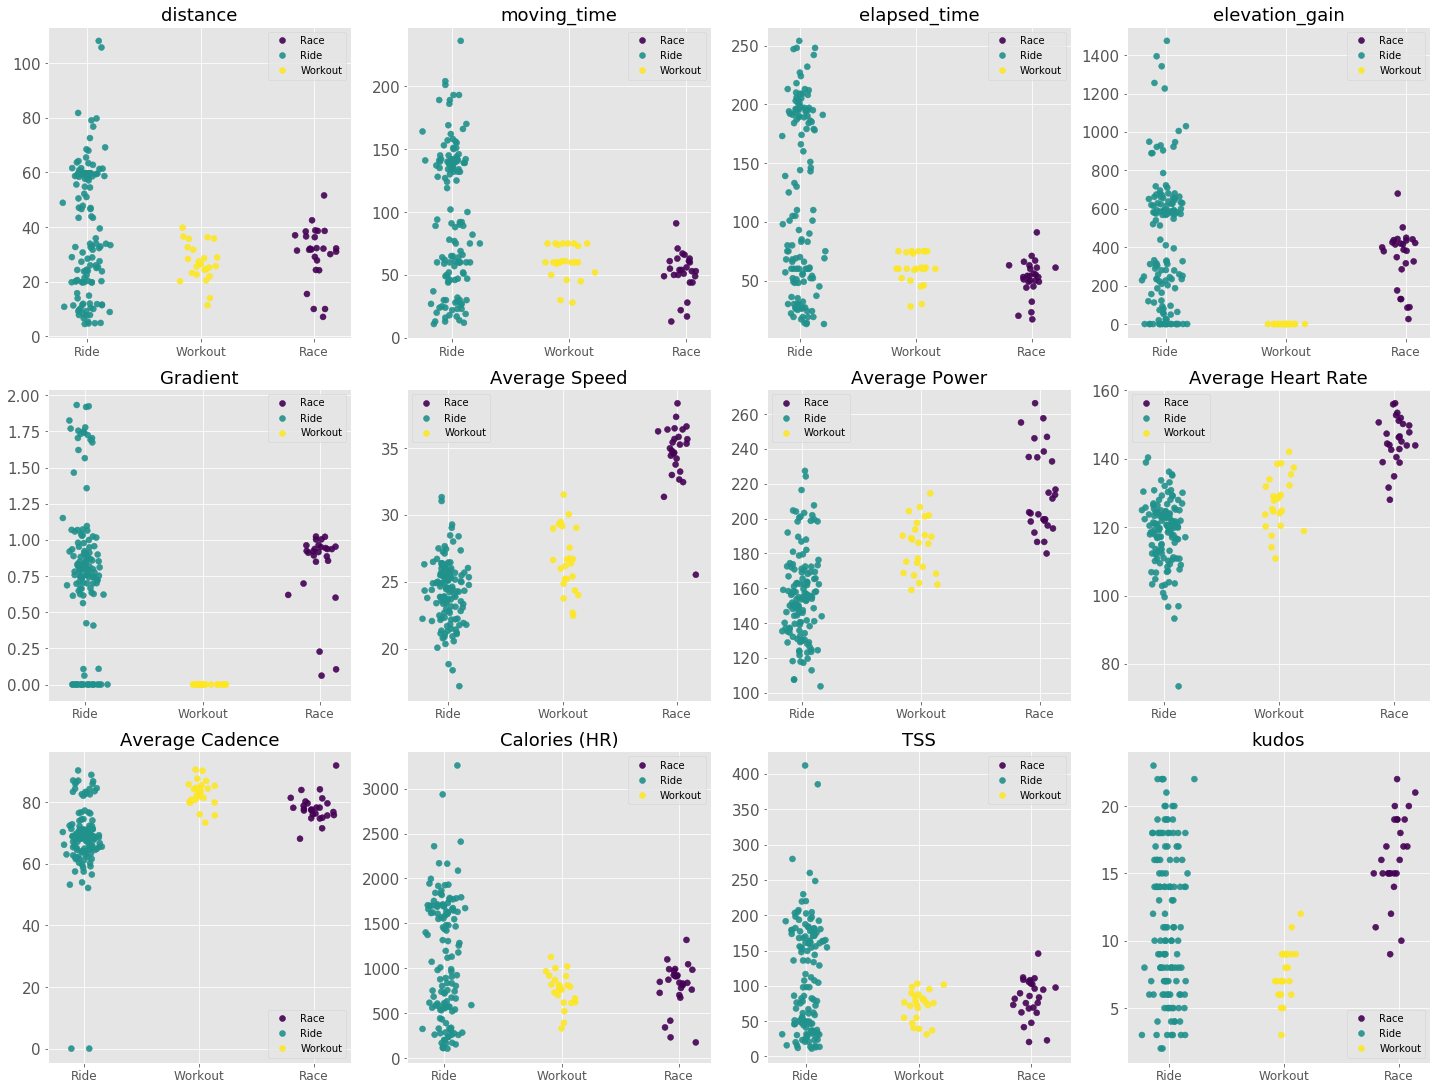

In [19]:
# For more detials about this function check used_function/custom_functions.py
custfun.plots_with_workout(df = important_dataframe, kind = "scatter")

### Graph Explanation
*  **Distance, Moving time, Elapsed time** - We can see that generally distance for *Race* and *Workout* is lower than distance for general *Ride*. Due to distance moving time and elapsed time are also low for *Race* and *Workout*.
*  **Elevation gain, Gradient** - Elevation gain for *Workout* is 0(Obvious - stationary equipment). Elevation gain for *Ride* is high compare to *Race*.(Maybe race tracks have even ground\[not much up and down roads\]). Elevation gain and Gradient has the same distribution across workout types.
*  **Average Speed, Average Heart Rate, Average Power** - Avg speed for *Race* is the highest(Obvious - Race has limited distance track, and contenstants are riding their bike fast in order to win), followed by *Workout*(due to less distance) and the least speed for *Ride*(Obvious - casual rides, no competition, more distance). **More Speed -> More Heart Rate -> More Power**.
*  **Average Cadence** - Cadence is speed at which rider turns the pedal. It is strange that it is simillar across various workout types. 
*  **Calories, TSS** - These two variables show same relation to workout types as Distance. **More Distance -> More Calories burnt -> More Stress on Body**
*  **Kudos** - More kudos to *Race* and *Ride* compare to *Workout*. We can't be sure of it. Maybe it is because of how kudos are higly correlated with distance.

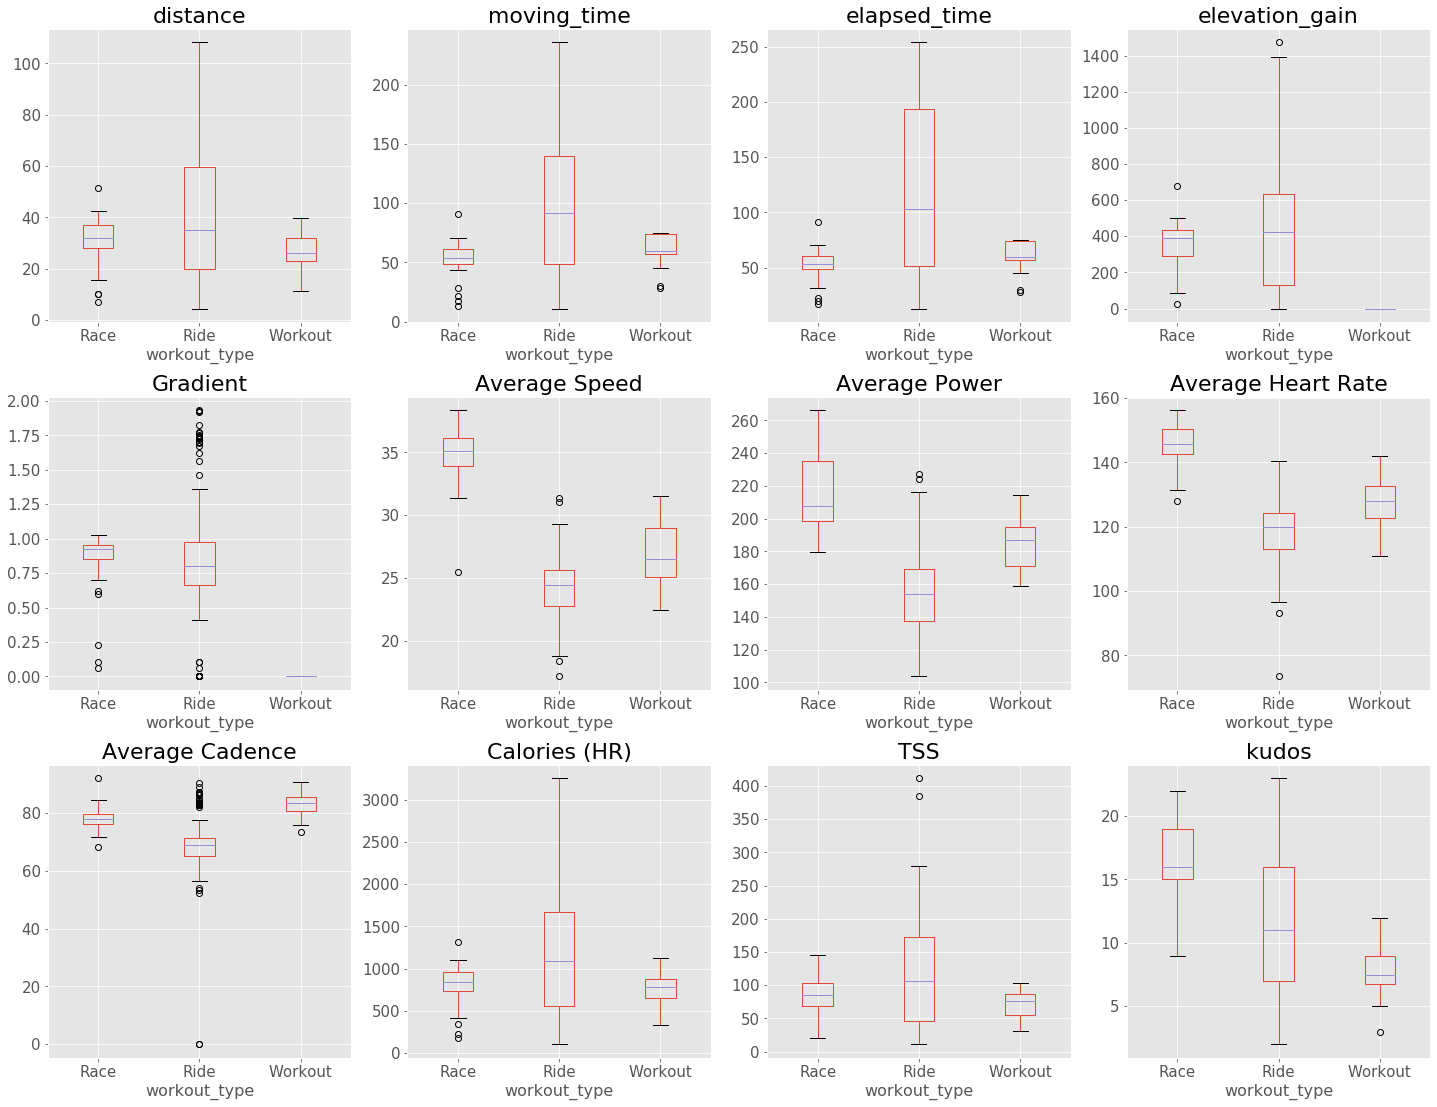

In [20]:
# For more detials about this function check used_function/custom_functions.py
custfun.plots_with_workout(df = important_dataframe, kind = "box")

### Graph Explanation
*  **Distance, Moving time, Elapsed time** - We can see that generally boxplot of distance for *Race* and *Workout* is simillar. While *Ride* shows high variation in all of three variables. (Similar outlier points in all three variables)
*  **Elevation gain, Gradient** - We can see that boxplots of Elevation gain and Gradient for *Race* and *Workout* is simillar. But for *Ride*, Elevation gain has high variation compare to Gradient(More outliers in Gradient for *Ride*).
*  **Average Speed, Average Heart Rate, Average Power** - Variation in the categories *Race*, *Ride* and *Workout* in Average Speed is almost same. This also applies to Average Heart Rate and Average Power.
*  **Average Cadence** - It is strange that it is simillar across various workout types. Though *Ride* has more outliers.
*  **Calories, TSS** - We can see that boxplots of Calories and TSS for *Race* and *Workout* is simillar. But for *Ride*, Calories has high variation compare to Gradient(More outliers in Gradient for *Ride*).
*  **Kudos** - More kudos to *Race* and *Ride* compare to *Workout*. But more variation in *Ride* compare to other two categories.

*  *We have seen all the variables, We noticed that **Ride** has more variation to it. Maybe it is because people are generally attending more Ride compare to other categories(Count of workout type **Ride** is higher compare to other categories) and also people are not paying more attention to things when they are just casually riding the bike. That explains more variations.

## Challenge 1
### What leads to more kudos? Is there anything to indicate which rides are more popular? Explore the relationship between the main variables and kudos. Show a plot and comment on any relationship you observe.

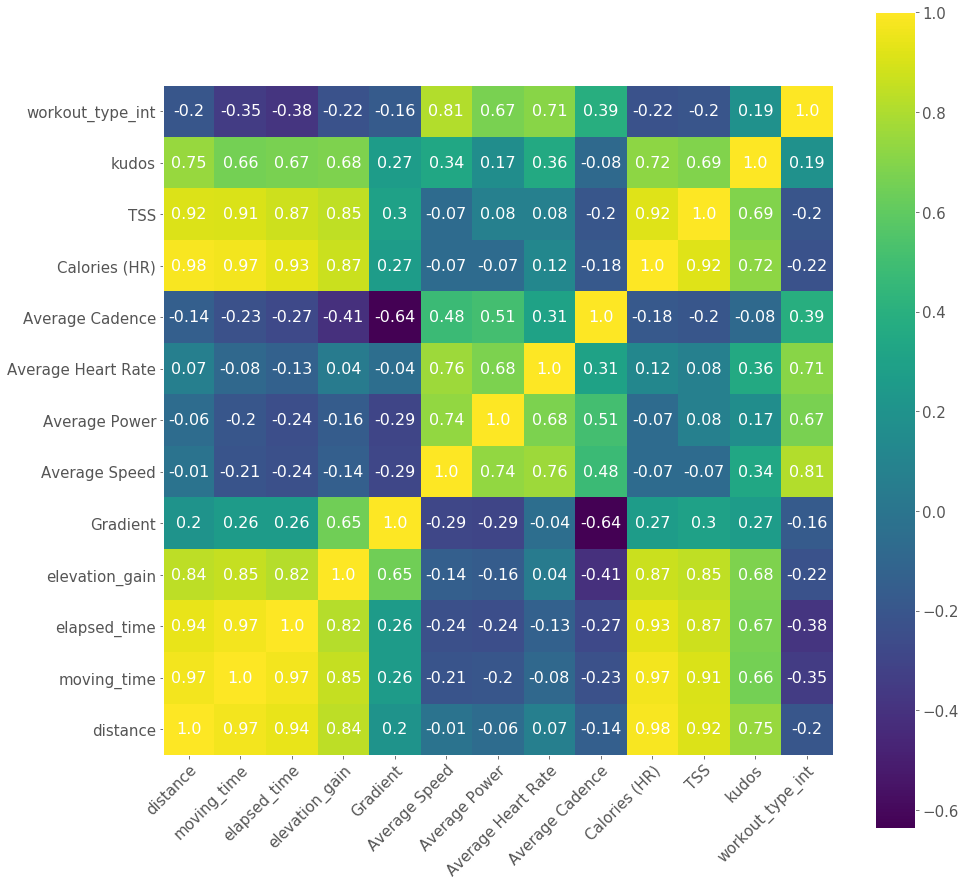

In [21]:
# Deleting the workout_type column
del important_dataframe["workout_type"]

# For more detials about this function check used_function/custom_functions.py
custfun.crete_correlogram(df = important_dataframe, size = (15, 15), corr_font_size = 16, xlab_rotation = 45)

### Graph Explanation
*  When we look at the kudos column we find that the correlation between **kudos** and **distance** is fairly strong(0.75). Now there are other variables which are highly correlated with kudos like **moving_time, elapsed_time, elevation_gain, Calories, TSS**. But we **cant** confidently make a **statement** here that **high numbers for these variables means more kudos**. Because distance has **strong correlation** with all those variable, So it might be a case of **confounding**.
*  **Gradient, Average Speed, Average Power, Average Heart Rate** has weak correlation with Kudos.

## Challenge 2
### Generate a plot that summarises the number of km ridden each month over the period of the data. Overlay this with the sum of the Training Stress Score and the average of the Average Speed to generate an overall summary of activity.

In [22]:
# Creating a copy for a dataframe
temp = strava_plus_cheetah.copy()

# Creating a new column called date_new using index column of strava_plus_cheetah
temp["date_new"] = pd.to_datetime(strava_plus_cheetah.index)

# Grouping distance, TSS and Average speed by month
per_month_distance = temp.set_index('date_new').groupby(pd.Grouper(freq = 'M'))['distance'].sum()
per_month_tss = temp.set_index('date_new').groupby(pd.Grouper(freq = 'M'))['TSS'].sum()
per_month_avg_avg_speed = temp.set_index('date_new').groupby(pd.Grouper(freq = 'M'))['Average Speed'].mean()

# Creating a new DataFrame
per_month = pd.DataFrame()
per_month["Date"] = per_month_distance.index
per_month["Distance"] = per_month_distance.values
per_month["TSS"] = per_month_tss.values
per_month["Avg Avg Speed"] = per_month_avg_avg_speed.values

# Rounding up whole dataframe to 2 digits
per_month = per_month.round(2)

# Removing the timezone detail
per_month["Date"] = per_month['Date'].dt.tz_localize(None)

#### Summary of distance, TSS and Average of Average Speed by months

In [23]:
per_month.iloc[:, :]

,Date,Distance,TSS,Avg Avg Speed
0,2018-01-31,46.2,114.80,30.23
1,2018-02-28,394.1,1195.20,24.79
2,2018-03-31,487.3,1390.84,26.16
3,2018-04-30,341.8,1027.21,24.26
4,2018-05-31,174.9,450.27,26.93
5,2018-06-30,193.4,586.49,27.04
6,2018-07-31,180.7,381.43,23.51
7,2018-08-31,127.5,522.13,25.17
8,2018-09-30,123.2,347.50,27.29
9,2018-10-31,426.6,1055.62,24.77


#### Plot Distance, TSS score and Average Speed grouped months

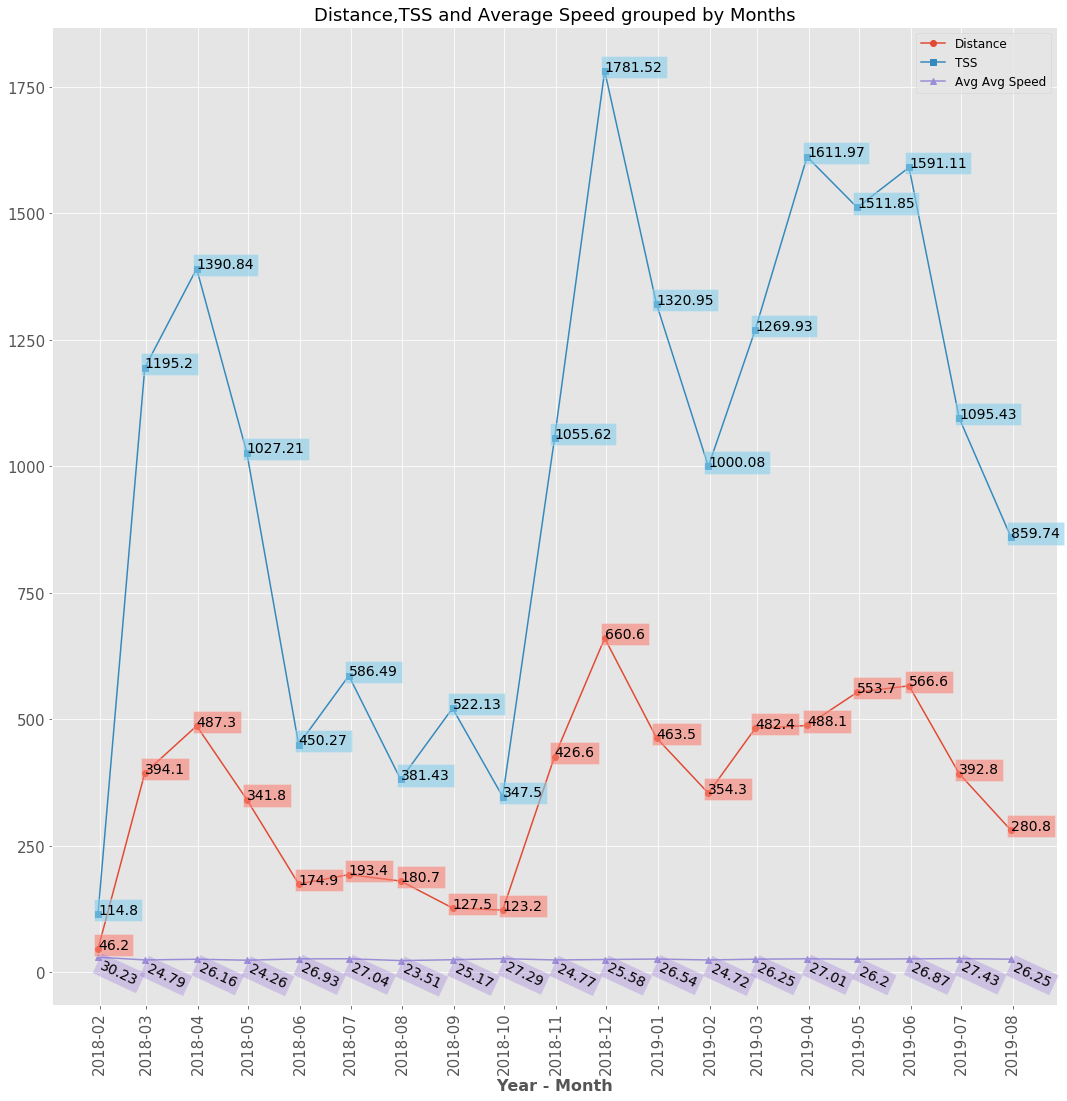

In [24]:
# Plotting an empty figure
plt.figure(figsize = (18,18))

# Plotting three lines
p1, = plt.plot(per_month["Date"], per_month["Distance"], marker = 'o', label = "Distance" )
p2, = plt.plot(per_month["Date"], per_month["TSS"], marker = 's', label = "TSS")
p3, = plt.plot(per_month["Date"], per_month["Avg Avg Speed"], marker = '^', label = "Avg Avg Speed")

# Setting xlabel and title of the plot 
plt.xlabel("Year - Month", fontsize = 16, fontweight = "bold")
plt.title("Distance,TSS and Average Speed grouped by Months", fontsize = 18)

# Setting x-axis locator, formatter and xticklabels
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(plt.gca().get_xticklabels(),rotation = 90)

# Plotting legends for lines
lines = [p1, p2, p3]
plt.legend(lines, [l.get_label() for l in lines], fontsize = 12)

# Plotting values for every data point
for i in range(per_month.shape[0]):
    
    plt.text(per_month["Date"][i], per_month["Distance"][i], str(per_month["Distance"][i]),
             fontsize = 14, bbox = dict(facecolor = 'salmon', alpha = 0.6))
    
    plt.text(per_month["Date"][i], per_month["TSS"][i], str(per_month["TSS"][i]),
             fontsize = 14, bbox = dict(facecolor = 'skyblue', alpha = 0.6))
    
    # -55 -> just so that value label won't overlap with the other elements
    plt.text(per_month["Date"][i], per_month["Avg Avg Speed"][i] - 55, str(per_month["Avg Avg Speed"][i]),
             fontsize = 14, bbox = dict(facecolor = 'mediumpurple', alpha = 0.3), rotation = 335)

plt.show()

## OR

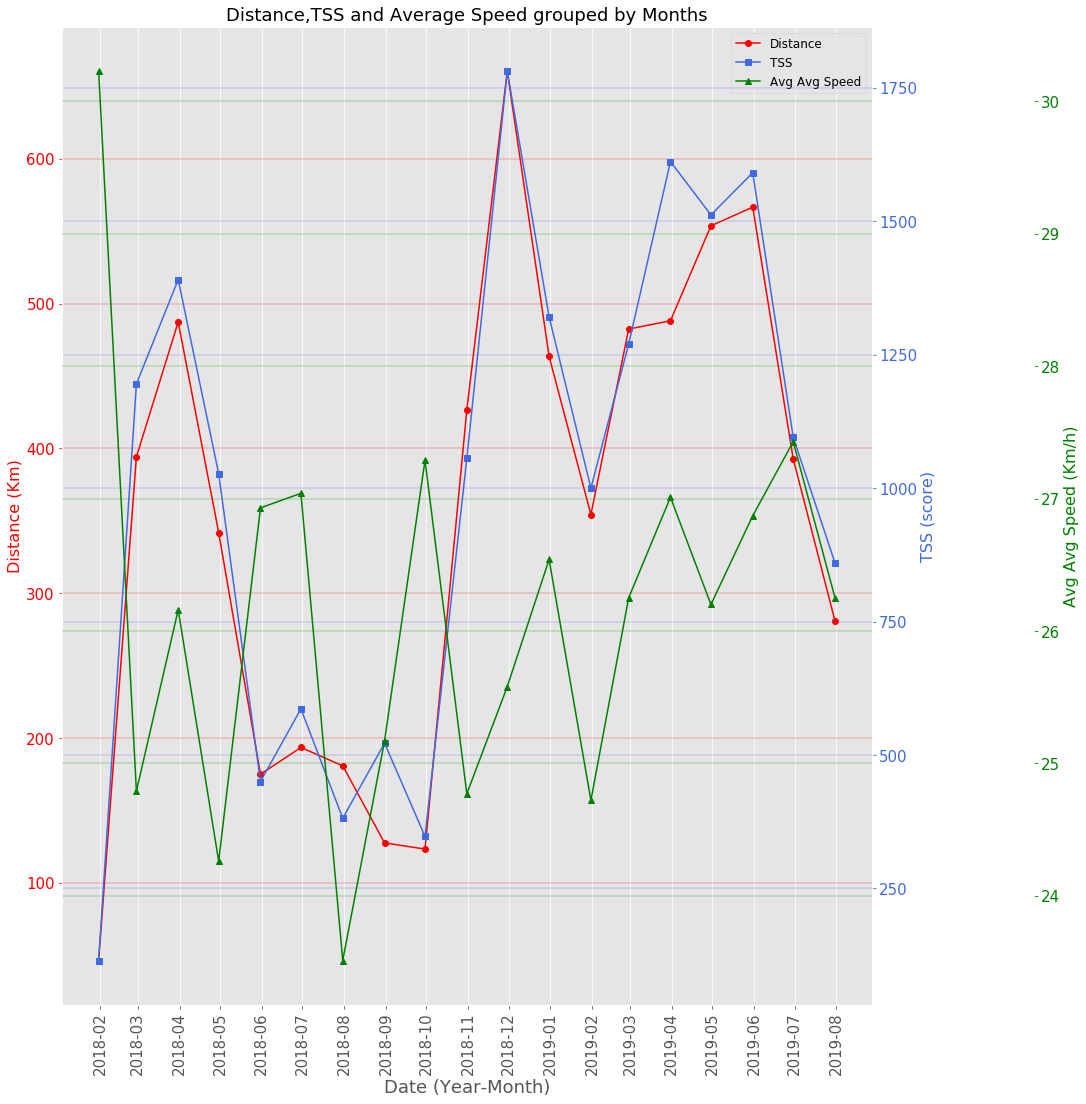

In [25]:
# For more detials about this function check used_function/custom_functions.py
custfun.create_lineplot_multiple_YAXIS(per_month, "Date", "Distance", "TSS", "Avg Avg Speed", 
                                       "Year-Month", "Km", "score", "Km/h", c1 = "red", c2 = "royalblue", c3 = "green")

### Graph Explanation
*  Minimum total distance travelled was **46.2km in Febuary of 2018**.
*  Maximum total distance travelled was **660.6km in December of 2018**.
*  Minimum TSS score was **114.8 in Febuary of 2018**.
*  Maximum TSS score was **1781.52 in December of 2018**.
*  Minimum Average Average Speed was **30.2km/h in Febuary of 2018**.
*  Maximum Average Average Speed was **23.51km/h in August of 2018**.
*  We can observe following patterns here:-

    *  1. Line graph for TSS and Distance are almost the same.
    *  2. Average Average Speed is in inverse relationship with Distance(TSS).
    *  3. After **Febuary** of both year(2018 and 2019) total distance travelled grouped by months and TSS score is **increasing** up to **May** of both years.
    *  4. After **May** of both year(2018 and 2019) total distance travelled by grouped by months and TSS score is **decreasing** up to **August**.
    *  5. There is no observable pattern in Average Average Speed.

## Challenge 3
### Generate a similar graph but one that shows the activity over a given month, with the sum of the values for each day of the month shown. So, if there are two rides on a given day, the graph should show the sum of the distances etc for these rides.

In [26]:
# Creating a copy for a dataframe
temp = strava_plus_cheetah.copy()

# Creating a new column called date_new using index column of strava_plus_cheetah
temp["date_new"] = pd.to_datetime(strava_plus_cheetah.index)

# Grouping the distance by day
per_day_distance = temp.set_index('date_new').groupby(pd.Grouper(freq = 'D'))['distance'].sum()

# Creating a new dataframe
per_day = pd.DataFrame()

# Creating columns in new dataframe
per_day["date"] = per_day_distance.index
per_day["date"] = pd.to_datetime(per_day["date"])
per_day["distance"] = per_day_distance.values

# Rounding up whole dataframe to 2 digits 
per_day = per_day.round(2)

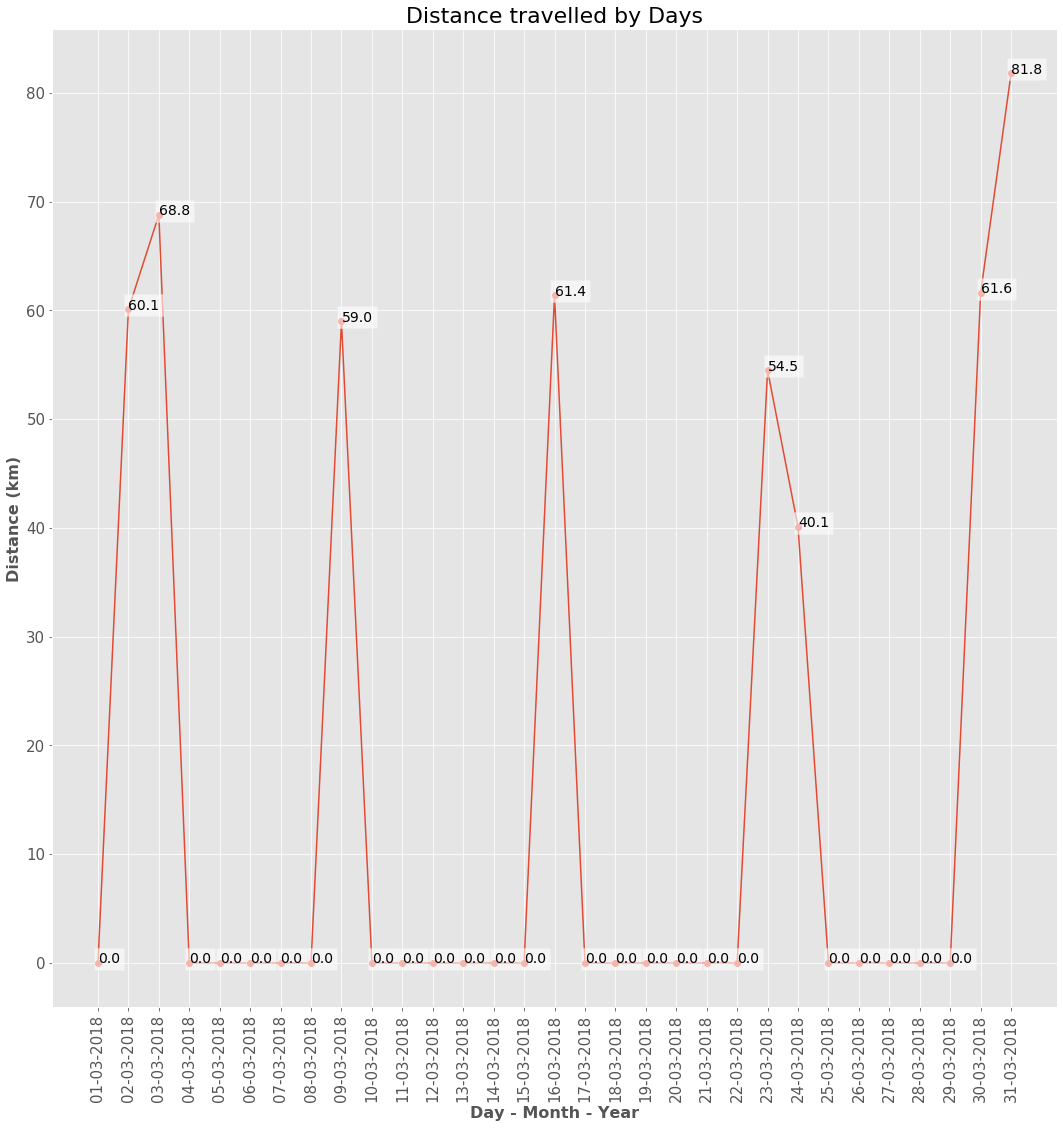

In [27]:
# Distance travelled over given month

## Try it yourself
month = 3

## For more detials about this function check used_function/custom_functions.py
custfun.activityOverGivenMonth(per_day, 2018, month)